# Ridge regression

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import pickle
import os

In [2]:
model_name = "ridge"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(aml_dir + 'nyc_demand_train.csv', parse_dates=['timeStamp'])

Create model pipeline:
- one-hot encode categorical variables
- grid search to find optimal values for the alpha parameter 

In [3]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [4]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
tscv = TimeSeriesSplit(n_splits=3)

In [5]:
param_grid = {'alpha': [ 1e-4, 1e-3, 1e-2, 0.1, 1.0]}
regr_cv = GridSearchCV(estimator=regr,
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('onehot', onehot), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.5s finished


Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('regr_cv', GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   ...*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2))])

Save model to AML shared directory

In [6]:
with open(aml_dir + model_name + '.pkl', 'wb') as f:
    pickle.dump(regr_pipe, f)

### Cross validation results

In [7]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
4,0.066832,0.003333,-4037.739712,-3948.063980,1,{'alpha': 1.0},1,-4367.502700,-3781.697790,-4029.299832,-3949.464648,-3716.416603,-4113.029501,0.009683,0.000850,265.871774,135.269230
3,0.105500,0.005502,-4038.054248,-3948.015753,0.1,{'alpha': 0.1},2,-4366.641969,-3781.656408,-4030.073518,-3949.410836,-3717.447258,-4112.980017,0.008842,0.001473,265.092703,135.265894
2,0.068340,0.007170,-4038.091544,-3948.015253,0.01,{'alpha': 0.01},3,-4366.559034,-3781.655983,-4030.159580,-3949.410275,-3717.556017,-4112.979500,0.002359,0.002776,265.013731,135.265856
1,0.095837,0.006500,-4038.095334,-3948.015248,0.001,{'alpha': 0.001},4,-4366.550772,-3781.655979,-4030.168277,-3949.410269,-3717.566953,-4112.979495,0.048539,0.002678,265.005822,135.265856
0,0.073193,0.003170,-4038.095714,-3948.015248,0.0001,{'alpha': 0.0001},5,-4366.549947,-3781.655979,-4030.169147,-3949.410269,-3717.568047,-4112.979495,0.004711,0.000622,265.005031,135.265856


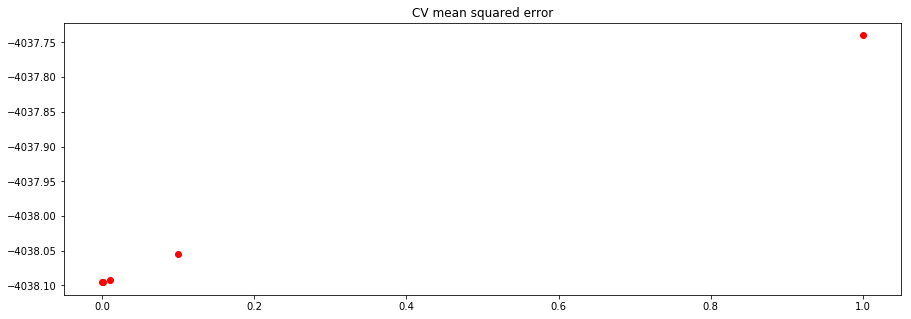

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro')
plt.title('CV mean squared error')
plt.show()